# Simple example of linear least squares with different types of regularisation

In [9]:
import numpy as np
from scipy.sparse import diags
from matplotlib import pyplot as plt

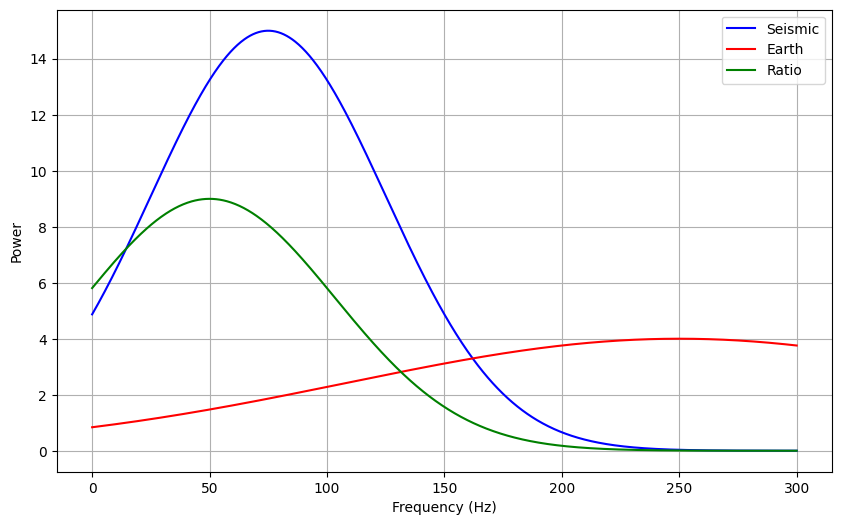

In [10]:
# generate synthetic data, two frequency spectra

# Generate frequency points
f = np.linspace(0, 300, 1000)

# Seismic spectrum - main peak plus secondary features
seismic_spectrum = 15 * np.exp(-(f - 75)**2 / 5000) 
                 
#seismic_spectrum = seismic_spectrum - seismic_spectrum[0] + 0.001

# Earth spectrum - broad peak with gentle rise and fall
earth_spectrum = 4 * np.exp(-(f - 250)**2 / 40000)

# Calculate ratio
ratio = seismic_spectrum / earth_spectrum

# Plot
plt.figure(figsize=(10, 6))
plt.plot(f, seismic_spectrum, 'b-', label='Seismic')
plt.plot(f, earth_spectrum, 'r-', label='Earth')
plt.plot(f, ratio, 'g-', label='Ratio')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.show()

The aim is to infer the earth spectrum from a given seismic spectrum

The problem can be posed in the form of d = GM

In [11]:
# ratio = seismic_spectrum / earth_spectrum
# seismic_spectrum = G * earth_spectrum
# where G = diag(ratio)
G = np.diag(ratio)

Then we have a noisy seismic trace, from which we want to determine the Earth spectrum

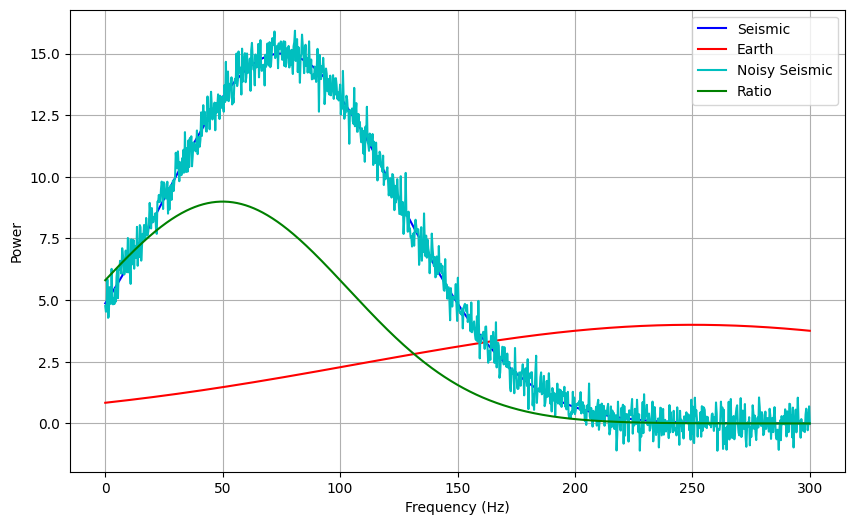

In [12]:
noisy_seismic_spectrum = seismic_spectrum + np.random.normal(0, 0.5, len(f))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(f, seismic_spectrum, 'b-', label='Seismic')
plt.plot(f, earth_spectrum, 'r-', label='Earth')
plt.plot(f, noisy_seismic_spectrum, 'c-', label='Noisy Seismic')
plt.plot(f, ratio, 'g-', label='Ratio')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.show()

We can do a simple division, but this will result in a noisy spectrum, or one that explodes where values are low or 0

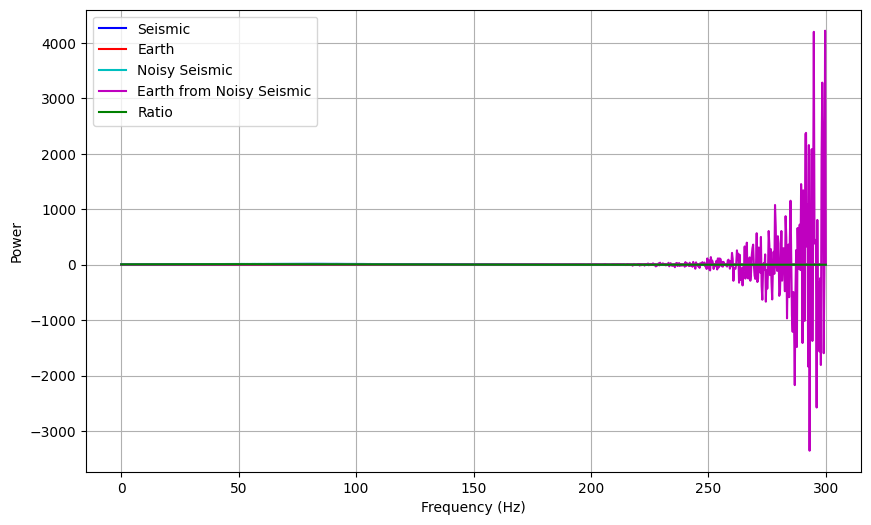

In [13]:
earth_spectrum_from_noisy = noisy_seismic_spectrum / ratio

# Plot
plt.figure(figsize=(10, 6))
plt.plot(f, seismic_spectrum, 'b-', label='Seismic')
plt.plot(f, earth_spectrum, 'r-', label='Earth')
plt.plot(f, noisy_seismic_spectrum, 'c-', label='Noisy Seismic')
plt.plot(f, earth_spectrum_from_noisy, 'm-', label='Earth from Noisy Seismic')
plt.plot(f, ratio, 'g-', label='Ratio')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# Parameters for the problem
# adjust these to see the effect of the different regularisation terms
alpha_smooth = 100.0  # smoothness regularization weight
alpha_mag = 0.1    # magnitude regularization weight
alpha_prior = 0.5  # prior model regularization weight

# here the prioir model will just be a zero vector
n = len(earth_spectrum)
m0 = np.zeros(n)

# Create smoothness operator (first-order differences)
L = diags([1, -1], [0, 1], shape=(n-1, n)).toarray()

# Set up the system in matrix form. When we solve this by least squares, we get a model that will minimise the data fit term and the regularisation terms
# [G       ] [m] = [d        ]  <- Fits the observed data: d = Gm
# [√α_s * L] [m] = [0        ]  <- Has low variations between adjacent points: sqrt(α_s)Lm = 0 -> Lm = 0
# [√α_m * I] [m] = [0        ]  <- Has small overall magnitude: sqrt(α_m)I] m = 0 -> m = 0
# [√α_p * I] [m] = [√α_p * m0]  <- Stays close to our prior model m0: sqrt(α_p)I] m = sqrt(α_p)m0 -> m = m0

# iinstead of d = Gm, we now have b = Am

# Build the matrix A 
A = np.vstack([
    G,  # data fit term
    np.sqrt(alpha_smooth) * L,  # smoothness regularization
    np.sqrt(alpha_mag) * np.eye(n),  # magnitude regularization
    np.sqrt(alpha_prior) * np.eye(n)  # prior model regularization
])

# Build the data vector b
b = np.hstack([
    noisy_seismic_spectrum,  # noisy data
    np.zeros(n-1),  # zeros for smoothness constraint 
    np.zeros(n),    # zeros for magnitude constraint
    np.sqrt(alpha_prior) * m0  # scaled prior model
])


# often we can't calculate the inverse of A directly because it is not square or it is singular
# instead, we invert A_transpose A
# b = A @ m 
# A_transpose A @ m = A_transpose b
# m = (A_transpose A)^-1 A_transpose b

ATA = A.T @ A
ATA_inv = np.linalg.inv(ATA) # calculate the inverse
ATb = A.T @ b
earth_spectrum_est = ATA_inv @  A.T @ b

Here we plot the inversion results. We see that for lower frequencies, the match is quite good. However, we don't fit the model anymore at high frequencies as the misfit on the data is much lower than the misfit due to the magnitude of the model (the magnitude regularisation here).

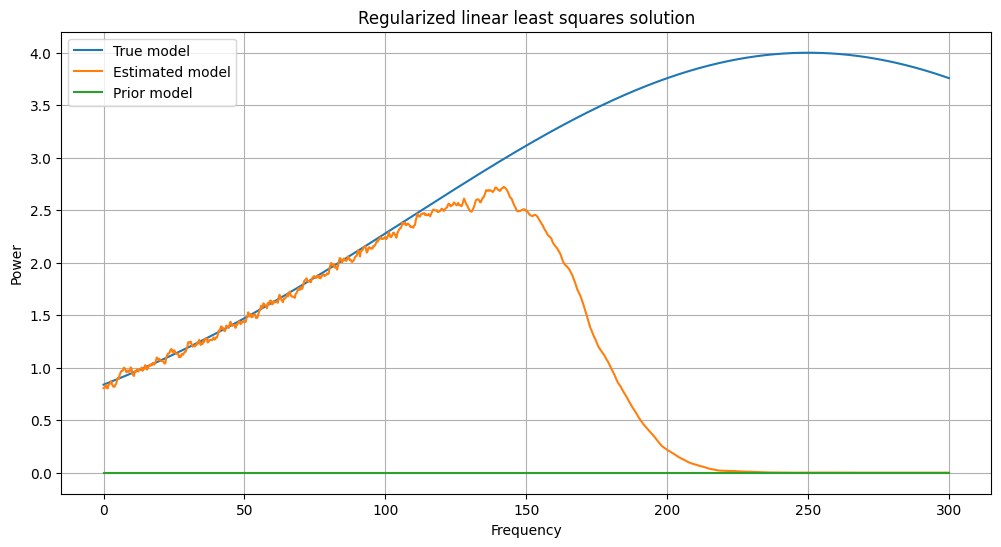

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(f, earth_spectrum, label='True model')
plt.plot(f, earth_spectrum_est, label='Estimated model')
plt.plot(f, m0, label='Prior model') # here 0s
plt.legend()
plt.title('Regularized linear least squares solution')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

Now, let's try with a different prior model.

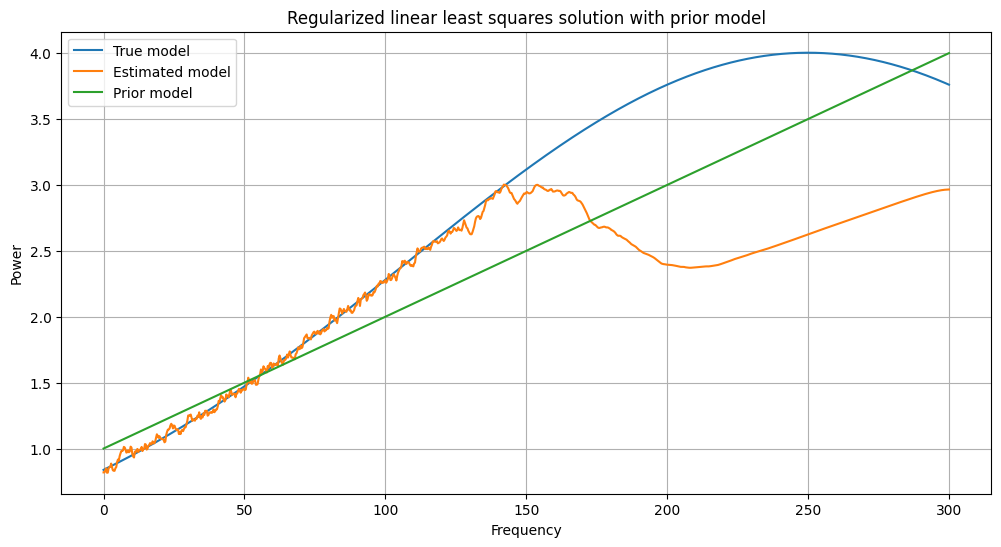

In [16]:
# Parameters for the problem
# adjust these to see the effect of the different regularisation terms
alpha_smooth = 100.0  # smoothness regularization weight
alpha_mag = 0.1    # magnitude regularization weight
alpha_prior = 0.3  # prior model regularization weight

# here the prioir model will just be a zero vector
n = len(earth_spectrum)
m0 = np.arange(n)*0.003 +1

# Create smoothness operator (first-order differences)
L = diags([1, -1], [0, 1], shape=(n-1, n)).toarray()

# Set up the system in matrix form. When we solve this by least squares, we get a model that will minimise the data fit term and the regularisation terms
# [G       ] [m] = [d        ]  <- Fits the observed data: d = Gm
# [√α_s * L] [m] = [0        ]  <- Has low variations between adjacent points: sqrt(α_s)Lm = 0 -> Lm = 0
# [√α_m * I] [m] = [0        ]  <- Has small overall magnitude: sqrt(α_m)I] m = 0 -> m = 0
# [√α_p * I] [m] = [√α_p * m0]  <- Stays close to our prior model m0: sqrt(α_p)I] m = sqrt(α_p)m0 -> m = m0

# iinstead of d = Gm, we now have b = Am

# Build the matrix A 
A = np.vstack([
    G,  # data fit term
    np.sqrt(alpha_smooth) * L,  # smoothness regularization
    np.sqrt(alpha_mag) * np.eye(n),  # magnitude regularization
    np.sqrt(alpha_prior) * np.eye(n)  # prior model regularization
])

# Build the data vector b
b = np.hstack([
    noisy_seismic_spectrum,  # noisy data
    np.zeros(n-1),  # zeros for smoothness constraint 
    np.zeros(n),    # zeros for magnitude constraint
    np.sqrt(alpha_prior) * m0  # scaled prior model
])

# often we can't calculate the inverse of A directly because it is not square or it is singular
# instead, we invert A_transpose A
# b = A @ m 
# A_transpose A @ m = A_transpose b
# m = (A_transpose A)^-1 A_transpose b

ATA = A.T @ A
ATA_inv = np.linalg.inv(ATA) # calculate the inverse
ATb = A.T @ b
earth_spectrum_est = ATA_inv @  A.T @ b


plt.figure(figsize=(12, 6))
plt.plot(f, earth_spectrum, label='True model')
plt.plot(f, earth_spectrum_est, label='Estimated model')
plt.plot(f, m0, label='Prior model') # here 0s
plt.legend()
plt.title('Regularized linear least squares solution with prior model')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

Here the result tends to follow the prior model more closely, being penalised for the size of the model at higher frequencies.